In [1]:
# Importação das bibliotecas necessárias
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [2]:
# Função para download do dataset
def download_dataset(url, output_path):
    if not os.path.exists(output_path):
        os.system(f'wget --no-check-certificate {url} -O {output_path}')

# Download e extração do dataset
data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_path = "/content/catsdogs.zip"
base_dir = "/content/cats_and_dogs_filtered/"
download_dataset(data_url, data_path)

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
# Diretórios de treino, validação e teste
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Carregamento dos datasets
def load_datasets(train_dir, validation_dir, img_size=(150, 150), batch_size=32):
    training_set = image_dataset_from_directory(
        train_dir,
        shuffle=True,
        batch_size=batch_size,
        image_size=img_size
    )
    val_dataset = image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        batch_size=batch_size,
        image_size=img_size
    )
    return training_set, val_dataset

training_set, val_dataset = load_datasets(train_dir, validation_dir)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
])


In [5]:
# Carregamento do modelo VGG16 pré-treinado
vgg = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)
vgg.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
# Criação do modelo
def create_model(base_model, data_augmentation):
    inputs = keras.Input(shape=(150, 150, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

model = create_model(vgg, data_augmentation)


In [7]:
# Compilação do modelo
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)


In [8]:
# Treinamento inicial
initial_epochs = 20
callbacks = [
    EarlyStopping(patience=5),
    TensorBoard(log_dir="logs")
]

history = model.fit(
    training_set,
    validation_data=val_dataset,
    epochs=initial_epochs,
    callbacks=callbacks
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - binary_accuracy: 0.6426 - loss: 2.5295 - val_binary_accuracy: 0.9050 - val_loss: 0.3962
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - binary_accuracy: 0.8529 - loss: 0.6857 - val_binary_accuracy: 0.9400 - val_loss: 0.2542
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - binary_accuracy: 0.8751 - loss: 0.5919 - val_binary_accuracy: 0.9490 - val_loss: 0.2139
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - binary_accuracy: 0.9208 - loss: 0.3454 - val_binary_accuracy: 0.9570 - val_loss: 0.1940
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - binary_accuracy: 0.9170 - loss: 0.3612 - val_binary_accuracy: 0.9600 - val_loss: 0.1797
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - binary_accuracy: 0.9241 - loss: 0.3121 - val_binary_accuracy: 0.9630 - val_loss: 0.1644
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - binary_accuracy: 0.9280 - loss: 0.2593 - val_binary_accuracy: 0.9660 - val_loss: 0.1666
Ep

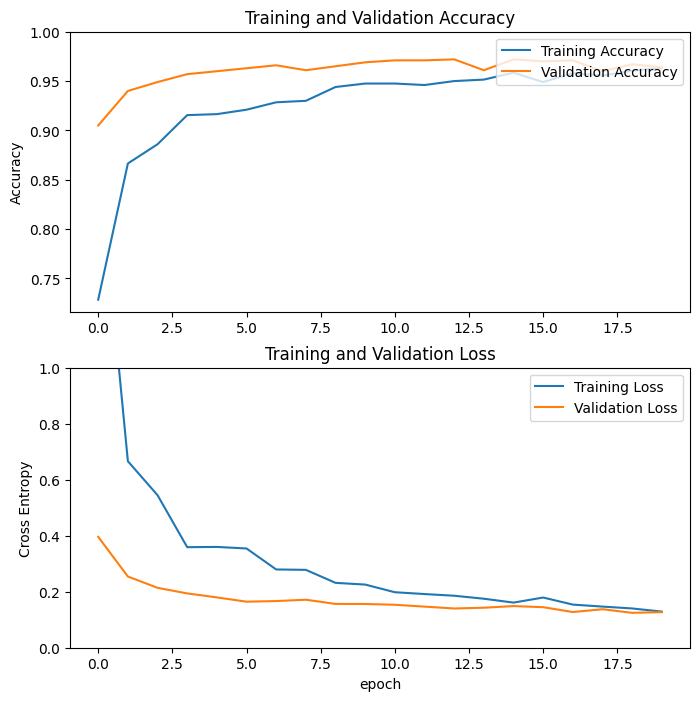

In [9]:
# Visualização dos resultados
def plot_training_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

plot_training_history(history)


Epoch 21/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 351ms/step - binary_accuracy: 0.9393 - loss: 0.1901 - val_binary_accuracy: 0.9660 - val_loss: 0.0869
Epoch 22/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - binary_accuracy: 0.9558 - loss: 0.0990 - val_binary_accuracy: 0.9640 - val_loss: 0.1043
Epoch 23/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - binary_accuracy: 0.9742 - loss: 0.0719 - val_binary_accuracy: 0.9690 - val_loss: 0.0935
Epoch 24/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - binary_accuracy: 0.9818 - loss: 0.0530 - val_binary_accuracy: 0.9740 - val_loss: 0.0827
Epoch 25/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - binary_accuracy: 0.9848 - loss: 0.0412 - val_binary_accuracy: 0.9690 - val_loss: 0.1019
Epoch 26/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 345ms/step - binary_accuracy: 0.9838 - loss: 0.0435 - val_binary_accuracy: 0.9730 - val_loss: 0.0794
Epoch 27/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - binary_accuracy: 0.9935 - loss: 0.0225 - val_binary_accuracy: 0.9730 - val_loss:

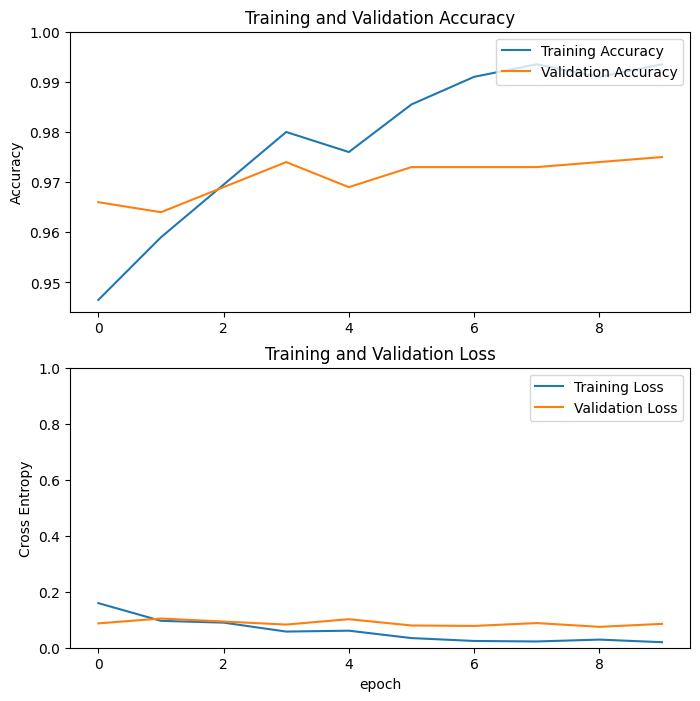

In [10]:
# Fine-tuning
def fine_tune_model(base_model, model, training_set, val_dataset, initial_epochs, fine_tune_epochs=10):
    base_model.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    history = model.fit(
        training_set,
        validation_data=val_dataset,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=initial_epochs,
        callbacks=callbacks
    )
    return history

fine_tune_history = fine_tune_model(vgg, model, training_set, val_dataset, initial_epochs)
plot_training_history(fine_tune_history)

